## 仓位管理

1. 马丁格尔加仓法


2. 反马丁格尔加仓法

## 1.马丁格尔加仓策略
 Martingale是一种亏损加仓模式 适合胜率高的策略
 
见 onBar ‘马丁格尔加仓模块’

用参数 n 控制加仓次数，参数 Ratio 控制加仓的进场位置。

### 算法如下：
if 持多头仓位 and 当前加仓次数 n < 3：

    if 亏损达到Ratio/100：

        加仓fixsize*(2**n)手数
        
        n = n+1

elif 持空头仓位 and 当前加仓次数 < 3：

    if 亏损达到Ratio：

        加仓fixsize*(2**n)手数
        
        n = n+1
### 当执行平仓信号，将 n 重置为 0 

if 持有多头仓位 and 死叉：

    n = 0
    
elif 持有空头仓位 and 金叉：

    n = 0

In [ ]:
    n = 0
    fixsize = 2
    transactionPrice = {}
    Ratio = 2
    
    self.transactionPrice = {s: 0 for s in self.symbolList}
#----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        
        # 马丁格尔加仓模块________________________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.n < 3):    # 持有多头仓位并且加仓次数不超过3次
            if (self.transactionPrice[symbol] - bar.close)/bar.close >= self.Ratio/100:   # 计算亏损比例,达到2%
                self.buy(symbol,bar.close*1.02,self.fixsize*(2**self.n))  # 加仓 2手、4手、8手
                self.n += 1  # 加仓次数减少 1 次
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.n < 3):    # 持有空头仓位并且加仓次数不超过3次
            if (bar.close - self.transactionPrice[symbol])/self.transactionPrice[symbol] >= self.Ratio/100:   # 计算亏损比例,达到2%
                self.short(symbol,bar.close*0.98,self.fixsize*(2**self.n))  # 加仓 2手、4手、8手
                self.n += 1  # 加仓次数减少 1 次
        
        # 发出状态更新事件
        self.putEvent()

### 具体策略使用案例

In [6]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import CtaTemplate
import numpy as np
import talib as ta
from datetime import timedelta

########################################################################
# 策略继承CtaTemplate
class DoubleMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'DoubleMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    barPeriod = 200
    fastWindow = 60     # 快速均线参数
    slowWindow = 120     # 慢速均线参数
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['barPeriod']  
    n = 0
    fixsize = 2
    transactionPrice = {}
    Ratio = 2
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        
        # 生成Bar数组
        self.setArrayManagerSize(self.barPeriod)
        self.transactionPrice = {s: 0 for s in self.symbolList}


        self.mail("chushihuaaaaaaaaaaaaaaaaaaaaaaaaa")
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        
        # 马丁格尔加仓模块________________________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.n < 3):    # 持有多头仓位并且加仓次数不超过3次
            if (self.transactionPrice[symbol] - bar.close)/bar.close >= self.Ratio/100:   # 计算亏损比例,达到2%
                self.buy(symbol,bar.close*1.02,self.fixsize*(2**self.n))  # 加仓 2手、4手、8手
                self.n += 1  # 加仓次数减少 1 次
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.n < 3):    # 持有空头仓位并且加仓次数不超过3次
            if (bar.close - self.transactionPrice[symbol])/self.transactionPrice[symbol] >= self.Ratio/100:   # 计算亏损比例,达到2%
                self.short(symbol,bar.close*0.98,self.fixsize*(2**self.n))  # 加仓 2手、4手、8手
                self.n += 1  # 加仓次数减少 1 次
        
        # 发出状态更新事件
        self.putEvent()
        
    def on30MinBar(self, bar):
        """30分钟K线推送"""
        symbol = bar.vtSymbol
    
        am30 = self.getArrayManager(symbol, "30m")

        if not am30.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am30.close, self.fastWindow)        
        slowMa = ta.EMA(am30.close, self.slowWindow)

        crossOver = fastMa[-1]>slowMa[-1] and fastMa[-2]<=slowMa[-2]     # 金叉上穿
        crossBelow = fastMa[-1]<slowMa[-1] and fastMa[-2]>=slowMa[-2]   # 死叉下穿
    
        
        # 构建进出场逻辑-------------------------------------------------
        # 金叉和死叉的条件是互斥
        if crossOver:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, self.fixsize)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                self.n = 0
                self.buy(symbol,bar.close*1.02, self.fixsize)

        # 死叉和金叉相反
        elif crossBelow :
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, self.fixsize)
            elif self.posDict[symbol+'_LONG'] >0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.n = 0
                self.short(symbol,bar.close*0.98, self.fixsize)
        
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(u'出现未知订单，需要策略师外部干预,ID:%s, symbol:%s,direction:%s,offset:%s'% (order.vtOrderID, order.vtSymbol, order.direction, order.offset))
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        self.transactionPrice[symbol] = trade.price
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 马丁格尔加仓模型绩效测试

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function DoubleMaStrategy.onBar at 0x0000017802558E18>, <__main__.DoubleMaStrategy object at 0x000001780262BB00>)
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function DoubleMaStrategy.on30MinBar at 0x0000017802558158>, <__main__.DoubleMaStrategy object at 0x000001780262BB00>)
2018-11-12 22:17:33.834128	开始回测
2018-11-12 22:17:33.834128	策略初始化
2018-11-12 22:17:33.835127	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-12 22:18:06.432909	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-12 22:18:06.446870	载入完成，数据量：12000
2018-11-12 22:18:06.446870	策略初始化完成
2018-11-12 22:18:06.446870	策略启动完成
2018-11-12 22:18:06.447869	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-12 22:18:06.459863	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-12 22:18:44.565342	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-12 22:18:44.597322	载入完成，数据量：43230
2018-11-12 22:18:44.5

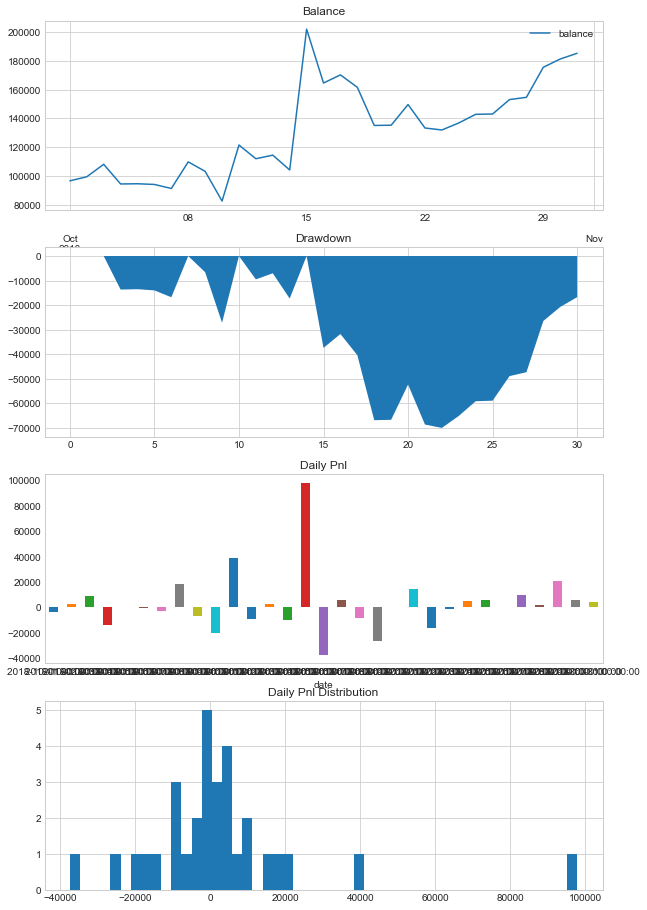

2018-11-12 22:20:09.105040	计算回测结果
2018-11-12 22:20:09.114033	交割单已生成
2018-11-12 22:20:09.114033	------------------------------
2018-11-12 22:20:09.114033	第一笔交易：	2018-10-04 22:30:00
2018-11-12 22:20:09.114033	最后一笔交易：	2018-10-31 15:58:00
2018-11-12 22:20:09.114033	总交易次数：	7
2018-11-12 22:20:09.114033	总盈亏：	84,581.45
2018-11-12 22:20:09.114033	最大回撤: 	-36,412.91
2018-11-12 22:20:09.114033	平均每笔盈利：	12,083.06
2018-11-12 22:20:09.115032	平均每笔滑点：	0.0
2018-11-12 22:20:09.115032	平均每笔佣金：	1,308.36
2018-11-12 22:20:09.115032	胜率		42.86%
2018-11-12 22:20:09.115032	盈利交易平均值	40,331.45
2018-11-12 22:20:09.115032	亏损交易平均值	-9,103.23
2018-11-12 22:20:09.115032	盈亏比：	4.43
2018-11-12 22:20:09.781694	策略回测统计图已保存


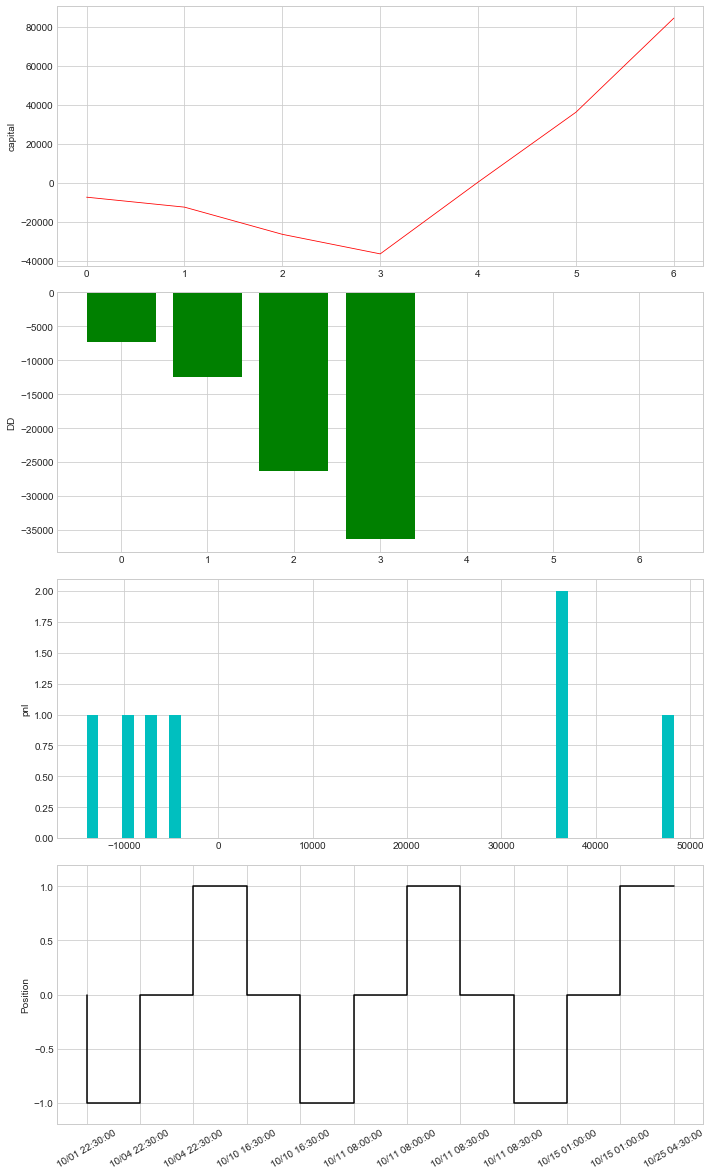

2018-11-12 22:20:10.410309	计算按日统计结果


In [7]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase('VnTrader_1Min_Db')
    engine.setStartDate(startDate, initHours=200)
    engine.setEndDate(endDate)
    engine.setSize(size)
    engine.setSlippage(slippage)
    engine.setRate(rate)
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(DoubleMaStrategy, {'symbolList': ['BTCUSDT:binance',
#                                                             'EOSUSDT:binance',
                                                            # 'ETHUSDT:binance'
#                                                             'eos_quarter:OKEX'
                                                            # 'tEOSUSD:bitfinex'
                                                            ]},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('BBandMa5MinStrategyReport.xlsx')

## 交易信息

In [8]:
tradeReport

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-10-01 22:30:00,空,,,0.0,,开仓,1,,6556.00,0.0,None,,,1,2018-10-01 22:30:00,2,1,BTCUSDT:binance,1
2018-10-04 22:30:00,多,,,0.0,,平仓,2,,6586.00,0.0,None,,,2,2018-10-04 22:30:00,2,2,BTCUSDT:binance,2
2018-10-04 22:30:00,多,,,0.0,,开仓,3,,6586.00,0.0,None,,,3,2018-10-04 22:30:00,2,3,BTCUSDT:binance,3
2018-10-10 16:30:00,空,,,0.0,,平仓,4,,6567.03,0.0,None,,,4,2018-10-10 16:30:00,2,4,BTCUSDT:binance,4
2018-10-10 16:30:00,空,,,0.0,,开仓,5,,6567.03,0.0,None,,,5,2018-10-10 16:30:00,2,5,BTCUSDT:binance,5
2018-10-11 08:00:00,多,,,0.0,,平仓,6,,6630.21,0.0,None,,,6,2018-10-11 08:00:00,2,6,BTCUSDT:binance,6
2018-10-11 08:00:00,多,,,0.0,,开仓,7,,6630.21,0.0,None,,,7,2018-10-11 08:00:00,2,7,BTCUSDT:binance,7
2018-10-11 08:30:00,空,,,0.0,,平仓,8,,6586.65,0.0,None,,,8,2018-10-11 08:30:00,2,8,BTCUSDT:binance,8
2018-10-11 08:30:00,空,,,0.0,,开仓,9,,6586.65,0.0,None,,,9,2018-10-11 08:30:00,2,9,BTCUSDT:binance,9


## 2.反马丁格尔加仓策略
 Anti-Martingale是一种亏损加仓模式 适合胜率较低而盈亏比高的策略
 见 onBar ‘反马丁格尔加仓模块’
 用参数 n 控制加仓次数，参数 Ratio 控制加仓的进场位置。
 ### 算法如下：
if 持多头仓位 and 当前加仓次数 n < 3：

    if 盈利达到Ratio/100：

        加仓fixsize*(2**n)手数
        
        n = n+1

elif 持空头仓位 and 当前加仓次数 < 3：

    if 盈利达到Ratio：

        加仓fixsize*(2**n)手数
        
        n = n+1
### 当执行平仓信号，将 n 重置为 0 

if 持有多头仓位 and 死叉：

    n = 0
    
elif 持有空头仓位 and 金叉：

    n = 0

In [ ]:
    n = 0
    fixsize = 2
    transactionPrice = {}
    Ratio = 0.02
    self.transactionPrice = {s: 0 for s in self.symbolList}
#----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
                
        # 反马丁格尔加仓模块______________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.n < 3):    # 持有多头仓位并且加仓次数不超过3次
            if (bar.close-self.transactionPrice[symbol])/self.transactionPrice[symbol]>= self.Ratio:   # 计算盈利比例,达到2%
                self.buy(symbol,bar.close*1.02,self.fixsize*(2**self.n))  # 加仓 2手、4手、8手
                self.n += 1  # 加仓次数减少 1 次
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.n < 3):    # 持有空头仓位并且加仓次数不超过3次
            if (self.transactionPrice[symbol]-bar.close)/bar.close >= self.Ratio:   # 计算盈利比例,达到2%
                self.short(symbol,bar.close*0.98,self.fixsize*(2**self.n))  # 加仓 2手、4手、8手
                self.n += 1  # 加仓次数减少 1 次
        
        # 发出状态更新事件
        self.putEvent()

### 具体策略使用案例

In [9]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import CtaTemplate
import numpy as np
import talib as ta
from datetime import timedelta

########################################################################
# 策略继承CtaTemplate
class DoubleMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'DoubleMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    barPeriod = 200
    fastWindow = 60     # 快速均线参数
    slowWindow = 120     # 慢速均线参数
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['barPeriod']  
    n = 0
    fixsize = 2
    transactionPrice = {}
    Ratio = 0.02
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        
        # 生成Bar数组
        self.setArrayManagerSize(self.barPeriod)
        self.transactionPrice = {s: 0 for s in self.symbolList}


        self.mail("chushihuaaaaaaaaaaaaaaaaaaaaaaaaa")
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
                
        # 反马丁格尔加仓模块______________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.n < 3):    # 持有多头仓位并且加仓次数不超过3次
            if (bar.close-self.transactionPrice[symbol])/self.transactionPrice[symbol]>= self.Ratio:   # 计算盈利比例,达到2%
                self.buy(symbol,bar.close*1.02,self.fixsize*(2**self.n))  # 加仓 2手、4手、8手
                self.n += 1  # 加仓次数减少 1 次
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.n < 3):    # 持有空头仓位并且加仓次数不超过3次
            if (self.transactionPrice[symbol]-bar.close)/bar.close >= self.Ratio:   # 计算盈利比例,达到2%
                self.short(symbol,bar.close*0.98,self.fixsize*(2**self.n))  # 加仓 2手、4手、8手
                self.n += 1  # 加仓次数减少 1 次
        
        # 发出状态更新事件
        self.putEvent()
        
    def on30MinBar(self, bar):
        """30分钟K线推送"""
        symbol = bar.vtSymbol
    
        am30 = self.getArrayManager(symbol, "30m")

        if not am30.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am30.close, self.fastWindow)        
        slowMa = ta.EMA(am30.close, self.slowWindow)

        crossOver = fastMa[-1]>slowMa[-1] and fastMa[-2]<=slowMa[-2]     # 金叉上穿
        crossBelow = fastMa[-1]<slowMa[-1] and fastMa[-2]>=slowMa[-2]   # 死叉下穿
        
        if crossOver:
            print('crossOver:',crossOver)
        elif crossBelow:
            print('crossBelow:',crossBelow)
        
        # 构建进出场逻辑-------------------------------------------------
        # 金叉和死叉的条件是互斥
        if crossOver:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, self.fixsize)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                self.n = 0
                self.buy(symbol,bar.close*1.02, self.fixsize)

        # 死叉和金叉相反
        elif crossBelow :
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, self.fixsize)
            elif self.posDict[symbol+'_LONG'] >0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.n = 0
                self.short(symbol,bar.close*0.98, self.fixsize)
        
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(u'出现未知订单，需要策略师外部干预,ID:%s, symbol:%s,direction:%s,offset:%s'% (order.vtOrderID, order.vtSymbol, order.direction, order.offset))
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        self.transactionPrice[symbol] = trade.price
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 绩效测试

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function DoubleMaStrategy.onBar at 0x00000178025A9730>, <__main__.DoubleMaStrategy object at 0x00000178060B35F8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function DoubleMaStrategy.on30MinBar at 0x00000178025A9840>, <__main__.DoubleMaStrategy object at 0x00000178060B35F8>)
2018-11-12 22:20:10.710130	开始回测
2018-11-12 22:20:10.710130	策略初始化
2018-11-12 22:20:10.712128	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-12 22:20:43.181124	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-12 22:20:43.192118	载入完成，数据量：12000
2018-11-12 22:20:43.193118	策略初始化完成
2018-11-12 22:20:43.193118	策略启动完成
2018-11-12 22:20:43.193118	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-12 22:20:43.199114	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-12 22:21:21.786771	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-12 22:21:21.823710	载入完成，数据量：43230
2018-11-12 22:21:21.8

D:\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.13.dev181104-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py:1287: RuntimeWarning: invalid value encountered in log
  df['return'] = (np.log(df['balance']) - np.log(df['balance'].shift(1))).fillna(0)


2018-11-12 22:22:46.188360	策略回测绩效图已保存


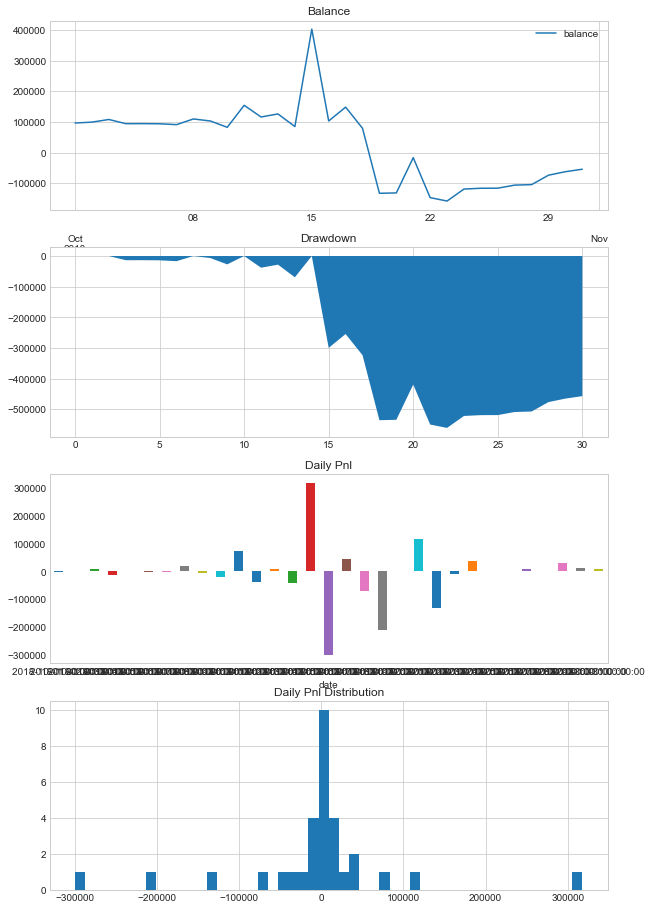

2018-11-12 22:22:47.079868	计算回测结果
2018-11-12 22:22:47.090987	交割单已生成
2018-11-12 22:22:47.090987	------------------------------
2018-11-12 22:22:47.090987	第一笔交易：	2018-10-04 22:30:00
2018-11-12 22:22:47.091955	最后一笔交易：	2018-10-31 15:58:00
2018-11-12 22:22:47.091955	总交易次数：	13
2018-11-12 22:22:47.091955	总盈亏：	-155,524.21
2018-11-12 22:22:47.091955	最大回撤: 	-235,872.17
2018-11-12 22:22:47.091955	平均每笔盈利：	-11,963.4
2018-11-12 22:22:47.091955	平均每笔滑点：	0.0
2018-11-12 22:22:47.091955	平均每笔佣金：	1,814.17
2018-11-12 22:22:47.091955	胜率		46.15%
2018-11-12 22:22:47.091955	盈利交易平均值	25,884.21
2018-11-12 22:22:47.091955	亏损交易平均值	-44,404.21
2018-11-12 22:22:47.091955	盈亏比：	0.58
2018-11-12 22:22:47.879498	策略回测统计图已保存


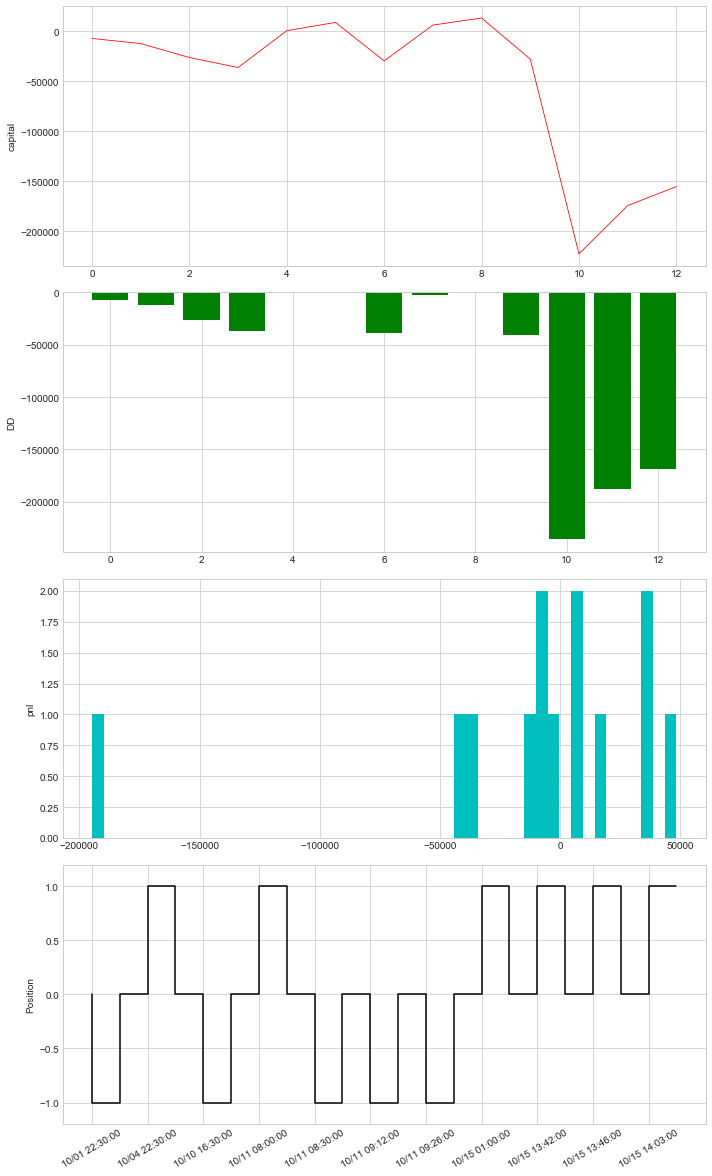

2018-11-12 22:22:48.429401	计算按日统计结果


In [10]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase('VnTrader_1Min_Db')
    engine.setStartDate(startDate, initHours=200)
    engine.setEndDate(endDate)
    engine.setSize(size)
    engine.setSlippage(slippage)
    engine.setRate(rate)
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(DoubleMaStrategy, {'symbolList': ['BTCUSDT:binance',
#                                                             'EOSUSDT:binance',
                                                            # 'ETHUSDT:binance'
#                                                             'eos_quarter:OKEX'
                                                            # 'tEOSUSD:bitfinex'
                                                            ]},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('BBandMa5MinStrategyReport.xlsx')

## 绩效报告

In [11]:
tradeReport

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-10-01 22:30:00,空,,,0.0,,开仓,1,,6556.00,0.0,None,,,1,2018-10-01 22:30:00,2,1,BTCUSDT:binance,1
2018-10-04 22:30:00,多,,,0.0,,平仓,2,,6586.00,0.0,None,,,2,2018-10-04 22:30:00,2,2,BTCUSDT:binance,2
2018-10-04 22:30:00,多,,,0.0,,开仓,3,,6586.00,0.0,None,,,3,2018-10-04 22:30:00,2,3,BTCUSDT:binance,3
2018-10-10 16:30:00,空,,,0.0,,平仓,4,,6567.03,0.0,None,,,4,2018-10-10 16:30:00,2,4,BTCUSDT:binance,4
2018-10-10 16:30:00,空,,,0.0,,开仓,5,,6567.03,0.0,None,,,5,2018-10-10 16:30:00,2,5,BTCUSDT:binance,5
2018-10-11 08:00:00,多,,,0.0,,平仓,6,,6630.21,0.0,None,,,6,2018-10-11 08:00:00,2,6,BTCUSDT:binance,6
2018-10-11 08:00:00,多,,,0.0,,开仓,7,,6630.21,0.0,None,,,7,2018-10-11 08:00:00,2,7,BTCUSDT:binance,7
2018-10-11 08:30:00,空,,,0.0,,平仓,8,,6586.65,0.0,None,,,8,2018-10-11 08:30:00,2,8,BTCUSDT:binance,8
2018-10-11 08:30:00,空,,,0.0,,开仓,9,,6586.65,0.0,None,,,9,2018-10-11 08:30:00,2,9,BTCUSDT:binance,9
